###**Imports**

In [1]:
import random
import numpy as np
import numpy
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Concatenate, Dot, Lambda, Input
from tensorflow.keras.layers import Conv2D, Activation,AveragePooling2D, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
from tensorflow.keras import utils
import matplotlib.pyplot as plt
from PIL import Image


import ntpath
from os import walk, path
from pathlib import Path
import random
import shutil,os
import math


# Imports for image plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%matplotlib inline
import sys






# Image Libraries
from PIL import Image, ImageFilter, ImageStat
import random
random.seed(42)
import imageio
import PIL
import os
import itertools
import glob
import cv2, glob
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
%matplotlib inline


from random import randrange


# Essentials
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve, KFold, cross_val_score, StratifiedKFold




/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###**Error**

In [2]:


class data_not_found(Exception):
    def __init__(self, *args):
        if args:
            self.message = args[0]
        else:
            self.message = None

    def __str__(self):
        if self.message:
            return '_Error :, {0} '.format(self.message)
        else:
            return 'errrrrrrrrrrrrrrrrrrr...'



class data_size_error(Exception):
    def __init__(self, *args):
        if args:
            self.message = args[0]
        else:
            self.message = None

    def __str__(self):
        if self.message:
            return '_Error :, {0} '.format(self.message)
        else:
            return 'errrrrrrrrrrrrrrrrrrr...'



class image_dimension_error(Exception):

    def __init__(self, *args):
        if args:
            self.message = args[0]
        else:
            self.message = None

    def __str__(self):
        if self.message:
            return '_Error :, {0} '.format(self.message)
        else:
            return 'errrrrrrrrrrrrrrrrrrr...'

class class_mismatch_error(Exception):

    def __init__(self, *args):
      if args:
          self.message = args[0]
      else:
          self.message = None

    def __str__(self):
        if self.message:
            return '_Error :, {0} '.format(self.message)
        else:
            return 'errrrrrrrrrrrrrrrrrrr...'

###**Parser**

In [3]:
class _Parser:

  @staticmethod
  def getF(directory, x="both"):
      # x could be "files" or "folders" or "both"

      if directory[-1] != "/":
        directory += "/"

      folders = []
      for f in walk(directory):
        folders.extend(f)
        # ???

      if x == "folders":
        return folders[1]

        
        
          
      if x == "files":
          return folders[2]
      else:
        return folders[1], folders[2]


  @staticmethod
  def parse_img_pair(x1, x2):

    
    image_string1 = tf.io.read_file(x1)
    image_string2 = tf.io.read_file(x2)

    #Don't use tf.image.decode_image, or the output shape will be undefined
    image1 = tf.image.decode_jpeg(image_string1, channels = image_shape(2))
    image2 = tf.image.decode_jpeg(image_string2, channels = image_shape(2))

    #This will convert to float values in [0, 1]
    image1 = tf.image.convert_image_dtype(image1, tf.float32)
    image2 = tf.image.convert_image_dtype(image2, tf.float32)

    image1 = tf.image.resize(image1, [image_shape(0), image_shape(1)])
    image2 = tf.image.resize(image2, [image_shape(0), image_shape(1)])
    return image1, image2
      

###**DATA**

In [4]:
class _Data:

    def __init__(self, instances_per_class, image_shape):
        self.image_shape = image_shape
        self.instances_per_class = instances_per_class


        self.train_instances_per_class = instances_per_class[0]
        self.val_instances_per_class = instances_per_class[1]
        self.ns_train = None
        self.ns_train_y = None
        self.ns_val   = None
        self.ns_val_y  = None
        self.ns_trainX1 = None
        self.ns_valX1 = None
        self.ns_trainX2 = None
        self.ns_valX2 = None
        self.clip_val = None
        self.train_ds = None
        self.val_ds = None

        self.total_train_instances = None
        self.total_val_instances = None
        

    def getMnist(self):
      (x_train, y_train), (x_test, y_test) = mnist.load_data()
      x_train = x_train.astype('float32')
      x_test = x_test.astype('float32')


      digit_indices_tr = [np.where(y_train == i)[0] for i in range(10)]

      ns_train = []
      ns_train_y = []

      count = 0
      for i in range(10):
        if self.train_instances_per_class < 0:
          for j in range(len(digit_indices_tr[i])):
            count += 1
            index = digit_indices_tr[i][j]
            ns_train_y.append(i)
            ns_train.append(x_train[index])
        else:
          for j in range(self.train_instances_per_class):
            count += 1
            index = digit_indices_tr[i][j]
            ns_train_y.append(i)
            ns_train.append(x_train[index])


      digit_indices_v = [np.where(y_test == i)[0] for i in range(10)]


      # get n-shot train data
      val_samples_per_cls = self.val_instances_per_class
      ns_val = []
      ns_val_y = []

      count = 0
      for i in range(10):
        if self.val_instances_per_class < 0:
          for j in range(len(digit_indices_v[i])):
            count += 1
            index = digit_indices_v[i][j]
            ns_val_y.append(i)
            ns_val.append(x_test[index])  
        else:
          for j in range(val_samples_per_cls):
            count += 1
            index = digit_indices_v[i][j]
            ns_val_y.append(i)
            ns_val.append(x_test[index])


      ns_train = np.asarray(ns_train, dtype="float32")
      ns_val = np.asarray(ns_val, dtype="float32")



      ns_train_y = np.asarray(ns_train_y)
      ns_val_y = np.asarray(ns_val_y)

      # ns_train_y = ns_train_y.astype('float32')
      # ns_val_y = ns_val_y.astype('float32')
      self.ns_train = ns_train
      self.ns_train_y = ns_train_y
      self.ns_val   = ns_val
      self.ns_val_y  = ns_val_y
      

      # return (ns_train,ns_train_y),(ns_val,ns_val_y)

    def show_rawd(self, to_show, cat=0):
      if self.ns_train_y is None:
        raise data_not_found("Either you have not initialized the data or it is deleted!")

      num_col = 5
      num_row = to_show//num_col
      # plot images
      fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))

      for i in range(to_show):
          ax = axes[i//num_col, i%num_col]
          # images[0][i][:,:,0] -> because it is (28,28,1) and imshow takes (28,82)
          # ax.imshow(tf.concat([images[0][i][:,:,0],images[1][i][:,:,0]],axis=1))

          # if image is (28,28) use below and comment above code
          if cat==0:
            ax.imshow(self.ns_train[i])
            ax.set_title('Label: {}'.format(self.ns_train_y[i]))
          else:
            ax.imshow(self.ns_val[i])
            ax.set_title('Label: {}'.format(self.ns_val_y[i]))              
      plt.tight_layout()
      plt.show()


    # make pairs
    def make_pairs(self,x, y):
        num_classes = max(y) + 1
        digit_indices = [np.where(y == i)[0] for i in range(num_classes)]

        pairs = []
        labels = []

        for idx1 in range(len(x)):
            # add a matching example
            x1 = x[idx1]
            label1 = y[idx1]
            idx2 = random.choice(digit_indices[label1])
            x2 = x[idx2]
            
            pairs += [[x1, x2]]
            labels += [1]
        
            # add a not matching example
            label2 = random.randint(0, num_classes-1)
            while label2 == label1:
                label2 = random.randint(0, num_classes-1)

            idx2 = random.choice(digit_indices[label2])
            x2 = x[idx2]
            
            pairs += [[x1, x2]]
            labels += [0]

        return np.array(pairs), np.array(labels).astype('float32')


    def _2d23d(self,x1,x2):
      x1 = tf.expand_dims(x1, axis=2)
      x2 = tf.expand_dims(x2, axis=2)
      return tf.image.grayscale_to_rgb(x1), tf.image.grayscale_to_rgb(x2)

    def train_preprocess(self,x1, x2):
        x1 = tf.image.random_flip_left_right(x1)
        x2 = tf.image.random_flip_left_right(x2)

        x1 = tf.image.random_brightness(x1, max_delta=32.0 / 255.0)
        x1 = tf.image.random_saturation(x1, lower=0.5, upper=1.5)

        x2 = tf.image.random_brightness(x2, max_delta=32.0 / 255.0)
        x2 = tf.image.random_saturation(x2, lower=0.5, upper=1.5)

        #Make sure the image is still in [0, 1]
        x1 = tf.clip_by_value(x1, 0.0, 1.0)
        x2 = tf.clip_by_value(x2, 0.0, 1.0)

        return x1, x2

    def clip_value(self,x1, x2):

        #Make sure the image is still in [0, 1]
        x1 = tf.clip_by_value(x1, self.clip_val[0], self.clip_val[1])
        x2 = tf.clip_by_value(x2, self.clip_val[0], self.clip_val[1])

        return x1, x2


    def get_dataset(self, batch_size=16, grey2rgb=0, aug=0, parallel_calls=4, clip_value=(0.0,1.0)):

      self.clip_val = clip_value

      pairs_train, labels_train = self.make_pairs(self.ns_train, self.ns_train_y)
      pairs_val, labels_val = self.make_pairs(self.ns_val, self.ns_val_y)

      # labels_train = labels_train.astype('float32')
      # labels_val = labels_val.astype('float32')

      self.total_train_instances = len(labels_train)
      self.total_val_instances = len(labels_val)

      x1 = pairs_train[:,0]
      x2 = pairs_train[:,1]

      y1, y2 = pairs_val[:,0],pairs_val[:,1]


      train_pair = tf.data.Dataset.from_tensor_slices((x1, x2))
      train_pair = train_pair.map(self.clip_value, num_parallel_calls=parallel_calls)
      if grey2rgb:
        train_pair = train_pair.map(self._2d23d, num_parallel_calls=parallel_calls)
        if aug:
          train_pair = train_pair.map(self.train_preprocess, num_parallel_calls=parallel_calls)

      train_label = tf.data.Dataset.from_tensor_slices(labels_train)
      train_ds = tf.data.Dataset.zip((train_pair, train_label)).shuffle(self.total_train_instances).batch(batch_size)



      val_pair = tf.data.Dataset.from_tensor_slices((y1, y2))
      if grey2rgb:
        val_pair = val_pair.map(self._2d23d, num_parallel_calls=parallel_calls)

      val_pair = val_pair.map(self.clip_value, num_parallel_calls=parallel_calls)


      val_label = tf.data.Dataset.from_tensor_slices(labels_val)
      val_ds = tf.data.Dataset.zip((val_pair, val_label)).shuffle(self.total_val_instances).batch(batch_size)



      self.train_ds = train_ds
      self.val_ds = val_ds 

      self.ns_train = None
      self.ns_train_y = None
      self.ns_val   = None
      self.ns_val_y  = None
      self.ns_trainX1 = None
      self.ns_valX1 = None
      self.ns_trainX2 = None
      self.ns_valX2 = None









    # Parser 4 directory, read directory and creates pairs

    def parse_dir(self, directory, folder_names=("train","val"), seed_val=0, pair_identical_images=True):

      train_dir = directory + "/" + folder_names[0] + "/"
      val_dir  = directory + "/" + folder_names[1] + "/"
      
      instances_per_class = self.instances_per_class
      classes = _Parser.getF(train_dir,"folders")
      val_classes = _Parser.getF(val_dir,"folders")

      if set(classes) != set(val_classes):
        raise class_mismatch_error("Your train and val directories do not have same name of classes!")
      val_classes = None
      # get filenames and keep record of smallest class of both train and val dir

      smallest_class = {}

      # train files
      fil_tr = {}
      mini = float('inf')
      for c in classes:
        fil_tr[c] = _Parser.getF(train_dir+c,"files")
        count = len(fil_tr[c])
        if (count < mini):
          mini = count
          smallest_class['train'] = {c:mini}

      # val_files
      fil_val = {}
      mini = float('inf')
      for c in classes:
        fil_val[c] = _Parser.getF(val_dir+c,"files")
        count = len(fil_val[c])
        if (count < mini):
          mini = count
          smallest_class['val'] = {c:mini}

      


      # validate instances_per_class required
      if instances_per_class[0] > list(smallest_class['train'].values())[0]:
        # err
        raise data_size_error(str(list(smallest_class['train'].keys())[0])+" has total " + str(list(smallest_class['train'].values())[0])+" instances")

      if instances_per_class[1] > list(smallest_class['val'].values())[0]:
        # err
        raise data_size_error(str(list(smallest_class['val'].keys())[0])+" has total " + str(list(smallest_class['val'].values())[0])+" instances")

      # sampling and shuffling of instances
      if instances_per_class[0] > 0:
        for c in classes:
          if seed_val >= 1:
            random.seed(seed_val)
            fil_tr[c] = random.sample(fil_tr[c], instances_per_class[0])
          if seed_val < 1:
            fil_tr[c] = random.sample(fil_tr[c], instances_per_class[0])
      else:
        for c in classes:
          if seed_val >= 1:
            random.seed(seed_val)
            random.Random(seed_val).shuffle(fil_tr[c])
            # fil_tr[c] = random.Random(seed_val).shuffle(fil_tr[c])
          if seed_val < 1:
            random.shuffle(fil_tr[c])
            # fil_tr[c] = random.shuffle(fil_tr[c])


      if instances_per_class[1] > 0:
        for c in classes:
          if seed_val >= 1:
            random.seed(seed_val)
            fil_val[c] = random.sample(fil_val[c], instances_per_class[1])
          if seed_val < 1:
            fil_val[c] = random.sample(fil_val[c], instances_per_class[1])
      else:
        for c in classes:
          if seed_val >= 1:
            random.seed(seed_val)
            random.Random(seed_val).shuffle(fil_val[c])
            # fil_val[c] = random.Random(seed_val).shuffle(fil_val[c])
          if seed_val < 1:
            random.shuffle(fil_val[c])
            # fil_val[c] = random.shuffle(fil_val[c])








      # ---------------------PAIRING-----------------#
      # for train
      # x1, x2, labels_tr = _Sampling.exhaustive(classes, fil_tr, train_dir, True)
      x1, x2, labels_tr = _Sampling.biconnect_random(classes, fil_tr, train_dir, True)


      # labels_tr = []
      # x1 = []
      # x2 = []
      # for i in range(len(classes)):
        
      #   for j in range(len(fil_tr[classes[i]])):
      #     img1 = fil_tr[classes[i]][j]
      #     p1 = train_dir+classes[i] + "/" + img1

      #     for k in range(len(classes)):
      #       for l in range(len(fil_tr[classes[k]])):
      #         label = 1 if i==k else 0

      #         img2 = fil_tr[classes[k]][l]

      #         # in case you don't want same images as pair
      #         if not pair_identical_images:
      #           if i==k:
      #             if img1==img2:
      #               continue
      #         p2 = train_dir+classes[k] + "/" + img2
      #         x1.append(p1)
      #         x2.append(p2)
      #         labels_tr.append(label)





      # for val
      # vx1, vx2, labels_val = _Sampling.exhaustive(classes, fil_val, val_dir, True)
      vx1, vx2, labels_val = _Sampling.biconnect_random(classes, fil_val, val_dir, True)
      # labels_val = []
      # vx1 = []
      # vx2 = []
      # for i in range(len(classes)):
        
      #   for j in range(len(fil_val[classes[i]])):
      #     img1 = fil_val[classes[i]][j]
      #     p1 = val_dir+classes[i] + "/" + img1

      #     for k in range(len(classes)):
      #       for l in range(len(fil_val[classes[k]])):
      #         label = 1 if i==k else 0

      #         img2 = fil_val[classes[k]][l]

      #         if not pair_identical_images:

      #           # in case you don't want same images as pair
      #           if i==k:
      #             if img1==img2:
      #               continue
                    

      #         p2 = val_dir+classes[k] + "/" + img2
      #         vx1.append(p1)
      #         vx2.append(p2)
      #         labels_val.append(label)

      (self.ns_trainX1,self.ns_trainX2,self.ns_train_y),(self.ns_valX1,self.ns_valX2,self.ns_val_y) = (x1,x2,labels_tr), (vx1,vx2,labels_val)
      # return (x1,x2,labels_tr), (vx1,vx2,labels_val)






    def flow_from_dir(self, batch_size=16, grey2rgb=0, rgb2grey=1, aug=0, parallel_calls=4, clip_value=(0.0,1.0)):
      self.clip_val = clip_value


      (x1,x2,labels_train), (vx1,vx2,labels_val) = (self.ns_trainX1,self.ns_trainX2,self.ns_train_y),(self.ns_valX1,self.ns_valX2,self.ns_val_y)
      
      self.total_train_instances = len(labels_train)
      self.total_val_instances = len(labels_val)
      # image_shape = self.image_shape


          
      def parse_img_pair(x1, x2):

        image_shape = self.image_shape

        image_string1 = tf.io.read_file(x1)
        image_string2 = tf.io.read_file(x2)

        #Don't use tf.image.decode_image, or the output shape will be undefined
        image1 = tf.image.decode_jpeg(image_string1, channels = image_shape[2])
        image2 = tf.image.decode_jpeg(image_string2, channels = image_shape[2])

        #This will convert to float values in [0, 1]
        image1 = tf.image.convert_image_dtype(image1, tf.float32)
        image2 = tf.image.convert_image_dtype(image2, tf.float32)

       
        
        image1 = tf.image.resize(image1, [image_shape[0], image_shape[1]])
        image2 = tf.image.resize(image2, [image_shape[0], image_shape[1]])


        if rgb2grey:
          image1 = tf.image.rgb_to_grayscale(image1)
          image1 = image1[:,:,0]
          image2 = tf.image.rgb_to_grayscale(image2)
          image2 = image2[:,:,0]

        return image1, image2
          

      # class attr
      image_shape = self.image_shape      


      labels_train = numpy.asarray(labels_train).astype('float32')
      labels_val = numpy.asarray(labels_val).astype('float32')




      train_pair = tf.data.Dataset.from_tensor_slices((x1, x2))
      train_pair = train_pair.map(parse_img_pair, num_parallel_calls=parallel_calls)
      train_pair = train_pair.map(self.clip_value, num_parallel_calls=parallel_calls)

      if grey2rgb:
        train_pair = train_pair.map(self._2d23d, num_parallel_calls=parallel_calls)
        if aug:
          train_pair = train_pair.map(self.train_preprocess, num_parallel_calls=parallel_calls)

      if grey2rgb ==0  and aug == 1:
        if image_shape[2] == 3:
          train_pair = train_pair.map(self.train_preprocess, num_parallel_calls=parallel_calls)
        else:
          raise image_dimension_error("Augmentation function used is for 3D images whereas you passed 2D")
          


      train_label = tf.data.Dataset.from_tensor_slices(labels_train)
      train_ds = tf.data.Dataset.zip((train_pair, train_label)).shuffle(self.total_train_instances).batch(batch_size)



      val_pair = tf.data.Dataset.from_tensor_slices((vx1, vx2))
      val_pair = val_pair.map(parse_img_pair, num_parallel_calls=parallel_calls)

      if grey2rgb:
        val_pair = val_pair.map(self._2d23d, num_parallel_calls=parallel_calls)

      val_pair = val_pair.map(self.clip_value, num_parallel_calls=parallel_calls)


      val_label = tf.data.Dataset.from_tensor_slices(labels_val)
      val_ds = tf.data.Dataset.zip((val_pair, val_label)).shuffle(self.total_val_instances).batch(batch_size)

      self.train_ds = train_ds
      self.val_ds = val_ds 

      # self.ns_train = None
      # self.ns_train_y = None
      # self.ns_val   = None
      # self.ns_val_y  = None
      self.ns_trainX1 = None
      self.ns_valX1 = None
      self.ns_trainX2 = None
      self.ns_valX2 = None



In [19]:
a = [[[1,2,3],[1,2,3],[1,2,3],[1,2,3]],[[1,2,3],[1,2,3],[1,2,3],[1,2,3]]]
image1 = tf.image.rgb_to_grayscale(a)
image1

<tf.Tensor: shape=(2, 4, 1), dtype=int32, numpy=
array([[[1],
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        [1]]], dtype=int32)>

In [23]:
image1[:,:,0]

<tf.Tensor: shape=(2, 4), dtype=int32, numpy=
array([[1, 1, 1, 1],
       [1, 1, 1, 1]], dtype=int32)>

In [ ]:
a = [[[1,2,3],[1,2,3]]]
image1 = tf.image.rgb_to_grayscale(a)
image1

In [5]:
import numpy
a = [[[1,2,3],[1,2,3]]]
numpy.asarray(a).shape

(1, 2, 3)

###**Sampler**

In [5]:
# need changes to allow dynamic change with pair vs triplet vs quadruplets etc
class _Sampling:

  # combine each image with each other O(N^4)
  @staticmethod
  def exhaustive(classes, files, directory, pair_identical_images):

    labels = []
    x1 = []
    x2 = []
    for i in range(len(classes)):
      
      for j in range(len(files[classes[i]])):
        img1 = files[classes[i]][j]
        p1 = directory+classes[i] + "/" + img1

        for k in range(len(classes)):
          for l in range(len(files[classes[k]])):
            label = 1 if i==k else 0
            img2 = files[classes[k]][l]

            # in case you don't want same images as pair
            if not pair_identical_images:
              if i==k:
                if img1==img2:
                  continue
            p2 = directory + classes[k] + "/" + img2
            x1.append(p1)
            x2.append(p2)
            labels.append(label)
    return x1, x2, labels


  #pair_identical_images to be used in below function 

  #each image is paired once with randomly chosen instance of its own class and
  # once with randomly chosen instance of another randomly chosen class
  @staticmethod
  def biconnect_random(classes, files, directory, pair_identical_images):

    labels = []
    x1 = []
    x2 = []

    files_list = []
    class_indices = []
    cummul_sum = 0

    # [[1,2,3],[5,6]] cummul_sum = [3,5]
    # when files_list is created to loop through images then this cummul_sum 
    # will tell what is the class of the current image
    

    for sublist in list(files.values()):
      files_list.extend(sublist)
      cummul_sum += len(sublist)
      class_indices.append(cummul_sum)

    total_images = len(files_list)
    index = 0
    for i in range(total_images):

      img1 = files_list[i]
      path1 = directory+classes[index] + "/" + img1

      # pair with same class image
      different_class_index = random.randint(0,len(classes)-1)
      img2_same_class = random.choice(files[classes[index]])
      path2_same_class = directory+classes[index] + "/" + img2_same_class

      
      while different_class_index == index:
        different_class_index = random.randint(0,len(classes)-1)
      img2_different_class = random.choice(files[classes[different_class_index]])
      path2_different_class = directory+classes[different_class_index] + "/" + img2_different_class

      label1 = 1
      label2 = 0

      x1.append(path1)
      x2.append(path2_same_class)
      labels.append(label1)

      x1.append(path1)
      x2.append(path2_different_class)
      labels.append(label2)

      if i+1 == class_indices[index]:
        index += 1 

    return x1, x2, labels


###**Loss**

In [6]:
class _Loss:
  
  @staticmethod
  def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(1-y_pred)
    margin_square = K.square(K.maximum(margin - (1-y_pred), 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)  


###**Geometry**

In [7]:
class _Geometry:
  
  @staticmethod
  def euclidean_distance(vects):
      x, y = vects
      sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
      return K.sqrt(K.maximum(sum_square, K.epsilon()))

###**Model**

In [8]:
class _Model:
  
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.input_height = input_shape[0]
    self.input_width = input_shape[1]
    self.input_channel = input_shape[2]

  from keras import backend as K


  def Siamese(self):
    input = Input((self.input_height,self.input_width,self.input_channel))
    x = tf.keras.layers.BatchNormalization()(input)
    x = Conv2D(4, (5,5), activation = 'sigmoid')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)
    x = Conv2D(16, (5,5), activation = 'sigmoid')(x)
    x = AveragePooling2D(pool_size = (2,2))(x)

    x = Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = Dense(10, activation = 'sigmoid')(x)
    dense = Model(input, x)


    input1 = Input((self.input_height,self.input_width,self.input_channel))
    input2 = Input((self.input_height,self.input_width,self.input_channel))

    dense1 = dense(input1)
    dense2 = dense(input2)

    merge_layer = Lambda(_Geometry.euclidean_distance)([dense1,dense2])
    dense_layer = Dense(1, activation="sigmoid")(merge_layer)
    # tf.keras.layers.BatchNormalization()
    return Model(inputs=[input1, input2], outputs=dense_layer)

###**Peek**

In [9]:
class _Peek:

  @staticmethod
  def eval(model, tf_data_set, to_show, show_axis=0, columns=5, img_size=(2,3)):
    batch_size = numpy.asarray(tf_data_set._batch_size)

    num_col = columns
    num_row = to_show//num_col

    imgs = []
    labels = []
    predictions = []
    for pairs, label in data.val_ds.take(batch_size):
      imgs.append(pairs)
      labels.extend(label)
    for pairs in imgs:
      predictions.extend(model.predict(pairs))

    
    y_val = img_size[1]
    x_val = img_size[0]
    # plot images
    fig, axes = plt.subplots(num_row, num_col, figsize=(y_val*num_col,x_val*num_row))


    ind = 0

    # for j in range(2):
    for i in range(to_show):
        ax = axes[i//num_col, i%num_col]

        if i<10:
          ind = i
        elif i%batch_size==0:
          ind = 0
        else:
          ind += 1  

        if show_axis == 0:
                ax.axes.xaxis.set_visible(False)
                ax.axes.yaxis.set_visible(False)
        

        # if image is (28,28) use below and comment above code
        ax.imshow(tf.concat([imgs[i//10][0][ind],imgs[i//10][1][ind]],axis=1))
        ax.set_title('y^: {}'.format(predictions[i]))

    plt.tight_layout()
    plt.show()



    



##Rest

### Debug

In [ ]:
import random
x = [1, 2, 3, 4, 5, 6]
random.shuffle(x)

In [ ]:
x

[2, 1, 4, 5, 3, 6]

In [ ]:
fil = random.Random().shuffle([0,1,2,3,4,5,6,7,8,9])

In [ ]:
print(fil)

None


###**directory**

In [81]:
params1 = {
    
    "instances_per_class" : (5,5),
    "image_shape"         : (64,64,3),
    "batch_size"          : 50,
    "grey2rgb"            : 0,
    "aug"                 : 1, 
    "parallel_calls"      : 4, 
    "clip_value"          : (0.0,1.0),
    "input_shape"         : (64,64,3),
    "loss"                : _Loss.contrastive_loss, 
    "optimizer"           : optimizer, 
    "metrics"             : ["accuracy"],
    "epochs"              : 49

}

In [ ]:
dir = '.'
!gdown --id 1XVslp6M_8EAwxWeuWLYqd2yQUeHuwUhm --output "{dir}/data.zip"
f = dir+"/data.zip"
data_p = "/content/data/"
!mkdir "$data_p"

!unzip "$f" -d "$data_p"


In [72]:
data = _Data(instances_per_class=params1["instances_per_class"], image_shape=params1["image_shape"])

In [30]:
dir = "/content/data"

In [73]:
data.parse_dir(dir)

In [74]:
data.flow_from_dir(batch_size=params1["batch_size"], grey2rgb=params1["grey2rgb"],rgb2grey=0, aug=params1["aug"], parallel_calls=params1["parallel_calls"], clip_value=params1["clip_value"])

In [82]:
m = _Model(input_shape=params1["input_shape"])

In [83]:
s = m.Siamese()

In [80]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
# optimizer = tensorflow.keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [84]:
s.compile(loss = params1["loss"], optimizer=params1["optimizer"], metrics=params1["metrics"])

In [ ]:
s.fit(data.train_ds, epochs=params1["epochs"], validation_data=data.val_ds)

In [ ]:
prdction=s.predict(data.val_ds)
prdction[0:10]

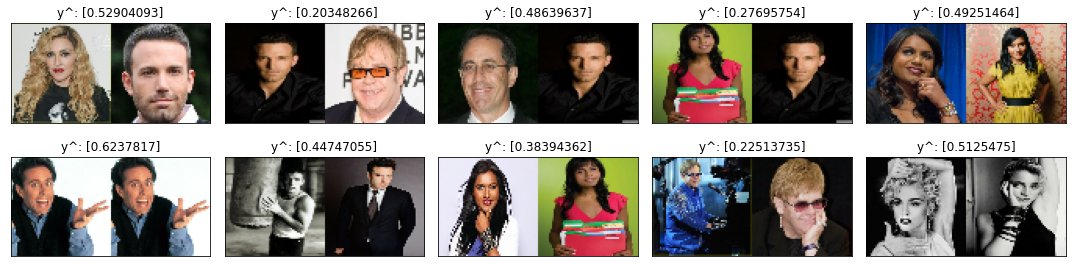

In [24]:
_Peek.eval(s, data.val_ds, 10, show_axis=0, columns=5, img_size=(2,3))

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

In [ ]:
s.save("/content/drive/My Drive/temp_data/dir_5_shot_72_oop4")

In [89]:
new_model = tf.keras.models.load_model('/content/drive/My Drive/temp_data/dir_5_shot_72_oop4',compile=False)

In [92]:
new_model.compile(loss = params1["loss"])

In [ ]:
new_model.evaluate(data.val_ds,return_dict=True)

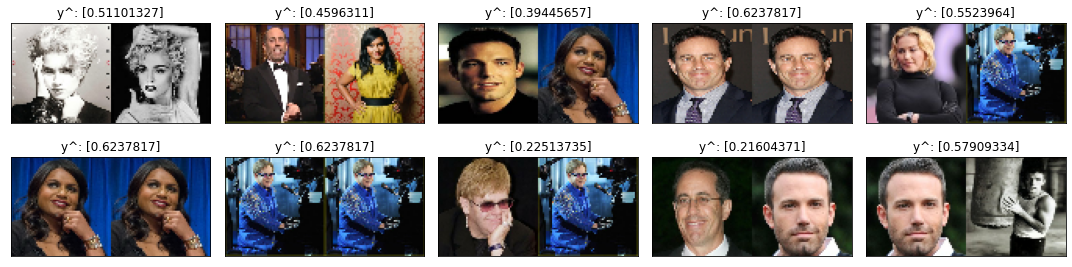

In [95]:
_Peek.eval(new_model, data.val_ds, 10, show_axis=0, columns=5, img_size=(2,3))

### **MNIST**

In [168]:
params2 = {
    
    "instances_per_class" : (5,5),
    "image_shape"         : (28,28,3),
    "batch_size"          : 50,
    "grey2rgb"            : 1,
    "aug"                 : 1, 
    "parallel_calls"      : 4, 
    "clip_value"          : (0.0,1.0),
    "input_shape"         : (28,28,3),
    "loss"                : _Loss.contrastive_loss, 
    "optimizer"           : optimizer, 
    "metrics"             : ["accuracy"],
    "epochs"              : 50

}

In [169]:
data = _Data(instances_per_class=params2["instances_per_class"], image_shape=params2["image_shape"])

In [170]:
_ = data.getMnist()

In [138]:
data.ns_train.shape

(50, 28, 28)

In [102]:
data.ns_val.shape

(50, 28, 28)

In [ ]:
# broken
data.show_rawd(to_show=10,cat=1)

In [171]:
data.get_dataset(batch_size=params2["batch_size"], grey2rgb=params2["grey2rgb"], aug=params2["aug"], parallel_calls=params2["parallel_calls"], clip_value=params2["clip_value"])

In [172]:
m = _Model(input_shape=params2["input_shape"])

In [173]:
s = m.Siamese()

In [110]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9
    )
# optimizer = tensorflow.keras.optimizers.SGD(learning_rate=lr_schedule)
optimizer = tensorflow.keras.optimizers.RMSprop(learning_rate=lr_schedule)

In [174]:
s.compile(loss = params2["loss"], optimizer=params2["optimizer"], metrics=params2["metrics"])

In [ ]:
s.fit(data.train_ds, epochs=params2["epochs"],validation_data=data.val_ds)


In [ ]:
gg=s.predict(data.val_ds)
gg[0:10]

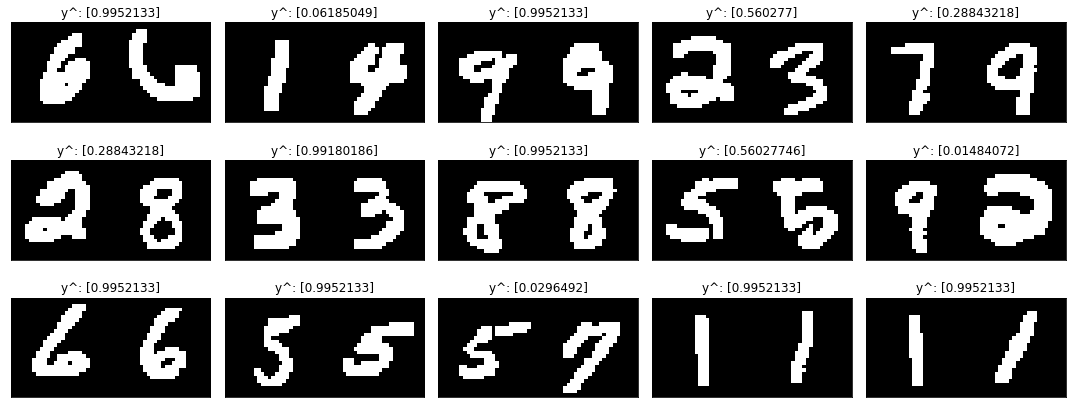

In [ ]:
_Peek.eval(s, data.val_ds, 15, show_axis=0, columns=5, img_size=(2,3))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [38]:
s.save("/content/drive/My Drive/temp_data/mnist_5_shot_77_oop4")

INFO:tensorflow:Assets written to: /content/drive/My Drive/temp_data/mnist_5_shot_77_oop4/assets


In [122]:
new_model2 = tf.keras.models.load_model('/content/drive/My Drive/temp_data/mnist_5_shot_77_oop4',compile=False)
new_model2.compile(loss = params2["loss"])


In [149]:
new_model2.evaluate(data.val_ds, return_dict=True)

2/2 [==============================] - 0s 13ms/step - loss: 0.3053


{'loss': 0.3052670657634735}

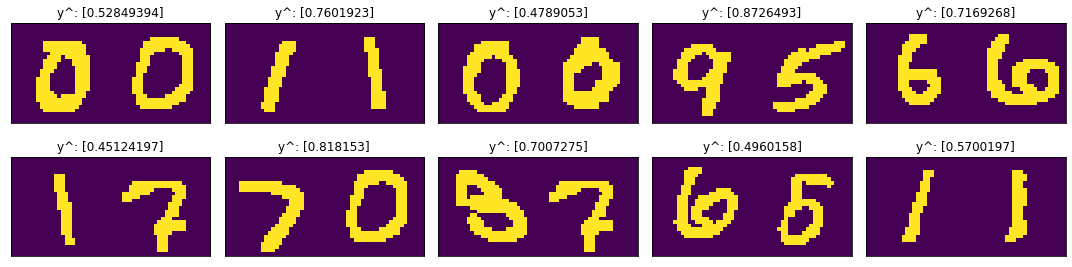

In [148]:
_Peek.eval(new_model2, data.val_ds, 10, show_axis=0, columns=5, img_size=(2,3))

##**Current stats**

**Directory**

5-shot -> 72% valid accuracy, 3D image , optimizer rmsprop with schedular


10 shot -> 78% observed without augmentation, 3D image, large no of epochs

**MNIST**




<99%>

      params = {
        
        "instances_per_class" : (-1,-1),
        "image_shape"         : (28,28),
        "batch_size"          : 16,
        "grey2rgb"            : 0,
        "aug"                 : 0, 
        "parallel_calls"      : 4, 
        "clip_value"          : (0.0,1.0),
        "input_shape"         : (28,28,1),
        "loss"                : _Loss.contrastive_loss, 
        "optimizer"           : RMSprop(), 
        "metrics"             : ["accuracy"],
        "epochs"              : 10

      }


5-shot

<77%> unstable

    

      Should get 77 within 150 epochs with these settings
      params2 = {
        
        "instances_per_class" : (5,5),
        "image_shape"         : (28,28,3),
        "batch_size"          : 50,
        "grey2rgb"            : 1,
        "aug"                 : 1, 
        "parallel_calls"      : 4, 
        "clip_value"          : (0.0,1.0),
        "input_shape"         : (28,28,3),
        "loss"                : _Loss.contrastive_loss, 
        "optimizer"           : optimizer, 
        "metrics"             : ["accuracy"],
        "epochs"              : 50

      }



    Model {

    class _Model:
  
      def __init__(self, input_shape):
        self.input_shape = input_shape
        self.input_height = input_shape[0]
        self.input_width = input_shape[1]
        self.input_channel = input_shape[2]

      from keras import backend as K


      def Siamese(self):
        input = Input((self.input_height,self.input_width,self.input_channel))
        x = tf.keras.layers.BatchNormalization()(input)
        x = Conv2D(4, (5,5), activation = 'sigmoid')(x)
        x = AveragePooling2D(pool_size = (2,2))(x)
        x = Conv2D(16, (5,5), activation = 'sigmoid')(x)
        x = AveragePooling2D(pool_size = (2,2))(x)

        x = Flatten()(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = Dense(10, activation = 'sigmoid')(x)
        dense = Model(input, x)


        input1 = Input((self.input_height,self.input_width,self.input_channel))
        input2 = Input((self.input_height,self.input_width,self.input_channel))

        dense1 = dense(input1)
        dense2 = dense(input2)

        merge_layer = Lambda(_Geometry.euclidean_distance)([dense1,dense2])
        dense_layer = Dense(1, activation="sigmoid")(merge_layer)
        # tf.keras.layers.BatchNormalization()
        return Model(inputs=[input1, input2], outputs=dense_layer)
    }
